# Plot together predictions from different models
1. Load predictions
2. Evaluate performance
3. Plot ROC curves on the same graph

In [14]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix


# To show all columns in a dataframe
pd.options.display.max_info_columns=250
pd.options.display.max_columns=500

# To make pretty plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

%matplotlib inline

In [15]:
df = pd.read_csv("../data/mimic-combined-filled-2984.csv")
df.head()

,stay_id,duration,over72h,over7d,over14d,over21d,gender,weight,height,pao2fio2ratio,co2_total_max,co2_total_min,ph_max,ph_min,lactate_max,lactate_min,heart_rate_max,heart_rate_min,mbp_ni_max,mbp_ni_min,mbp_arterial_max,mbp_arterial_min,resp_rate_max,resp_rate_min,spo2_max,spo2_min,temp_max,temp_min,glucose_max,glucose_min,epinephrine,vasopressin,dobutamine,norepinephrine,phenylephrine,dopamine,count_of_vaso,fio2_max,fio2_min,peep_max,peep_min,plateau_pressure_max,plateau_pressure_min,rrt,neuroblocker,admission_location,insurance,language,ethnicity,marital_status,age,hours_in_hosp_before_intubation,congestive_heart_failure,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,sinus_rhythm,SOFA,apsiii,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,30074509,217.500000,1,0,0,0,M,122.0,173.0,182.500000,35.0,26.0,7.40,7.23,2.2,0.3,128.0,76.0,119.0,71.0,111.0,65.0,31.0,11.0,100.0,87.0,38.33,34.00,155.0,89.0,1,1,1,1,1,1,6,100.0,40.0,13.0,5.0,29.0,16.0,0,0,EMERGENCY ROOM,Medicaid,ENGLISH,WHITE,SINGLE,59,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,9,61,17638202,58483943.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,30488518,460.000000,1,1,0,0,F,111.0,170.0,326.666667,37.0,33.0,7.49,7.43,2.1,1.1,101.0,47.0,106.0,27.0,108.0,43.0,25.0,5.0,100.0,91.0,38.17,36.67,446.0,132.0,1,1,1,1,1,1,6,50.0,30.0,10.0,0.0,19.0,17.0,0,0,EMERGENCY ROOM,Medicaid,ENGLISH,WHITE,DIVORCED,61,96,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.0,3,47,10878728,54819095.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0
2,30679928,623.958333,1,1,0,0,F,82.2,157.0,97.500000,30.0,12.0,7.48,7.17,6.8,1.5,203.0,75.0,107.0,44.0,261.0,62.0,37.0,12.0,100.0,92.0,39.22,35.00,390.0,59.0,1,1,1,1,1,1,6,100.0,40.0,10.0,0.0,26.0,16.0,1,0,EMERGENCY ROOM,Medicare,ENGLISH,WHITE,DIVORCED,83,6,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1.0,13,83,15355458,57154020.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0
3,30767458,186.666667,1,0,0,0,M,87.6,178.0,234.285714,29.0,25.0,7.45,7.42,0.9,0.7,144.0,58.0,113.0,53.0,160.0,56.0,24.0,8.0,100.0,92.0,38.78,36.78,127.0,74.0,1,1,1,1,1,1,6,100.0,35.0,5.6,0.0,15.0,10.0,0,0,TRANSFER FROM HOSPITAL,Medicare,ENGLISH,WHITE,MARRIED,67,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2,40,12562737,56148939.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0
4,30963638,280.000000,1,0,0,0,M,143.3,178.0,110.000000,36.0,31.0,7.46,7.41,1.6,1.2,130.0,70.0,114.0,49.0,113.0,55.0,45.0,10.0,100.0,78.0,39.56,36.78,206.0,92.0,1,1,1,1,1,1,6,40.0,35.0,11.0,0.0,27.0,22.0,0,0,EMERGENCY ROOM,Medicaid,ENGLISH,WHITE,SINGLE,65,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,7,41,13185626,51204041.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0


In [30]:
df.over72h.value_counts() / df.shape[0]

0    0.508378
1    0.491622
Name: over72h, dtype: float64

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.over72h)
print("The training set contains %d records:" % df_train.shape[0])
print(df_train.over72h.value_counts())
print("The test set contains %d records:" % df_test.shape[0])
print(df_test.over72h.value_counts())

The training set contains 2387 records:
0    1213
1    1174
Name: over72h, dtype: int64
The test set contains 597 records:
0    304
1    293
Name: over72h, dtype: int64


In [17]:
y = df_test.over72h.values
y.shape

(597,)

In [18]:
y_proba_emr = np.load("../results/y-proba-emr.npy")
y_proba_cxr = np.load("../results/y-proba-cxr.npy")
y_proba_combined = np.load("../results/y-proba-combined-v2.npy")

In [19]:
def evaluate_model(y, y_proba, class_names, string, thresh=None, show_plots=True, digits=2, save_figures=False, filename=""):
    # Generate predictions
    if thresh:
        y_pred = np.where(y_proba[:,1] > thresh, 1, 0)
    else:
        y_pred = np.argmax(y_proba, axis=1)
    print("Model evaluation on the %s set" % string)
    print()
    # Classification report
    print("Classification report:")
    print(classification_report(y, y_pred, digits=digits))
    
    # Plot confusion matrix
    plt.figure();
    sns.heatmap(confusion_matrix(y, y_pred, normalize="true"), 
                annot=confusion_matrix(y, y_pred), fmt="d",
                cmap="Blues", cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.yticks(rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix");
    if save_figures:
        plt.savefig(filename + "_CM.png", bbox_inches='tight', dpi=300, transparent=True, pad_inches=0);

In [20]:
class_names = ("Less than 72 hours", "Over 72 hours")

Model evaluation on the test set

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       304
           1       0.80      0.82      0.81       293

    accuracy                           0.81       597
   macro avg       0.81      0.81      0.81       597
weighted avg       0.81      0.81      0.81       597



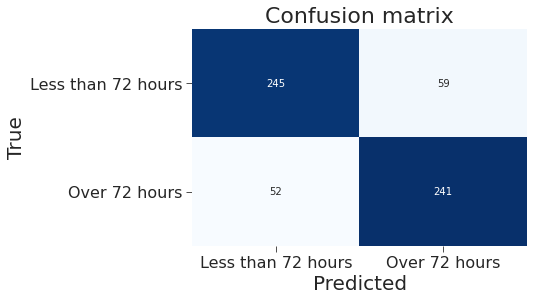

In [21]:
evaluate_model(y, y_proba_emr, class_names, "test", show_plots=False)

Model evaluation on the test set

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.59      0.57       304
           1       0.53      0.48      0.51       293

    accuracy                           0.54       597
   macro avg       0.54      0.54      0.54       597
weighted avg       0.54      0.54      0.54       597



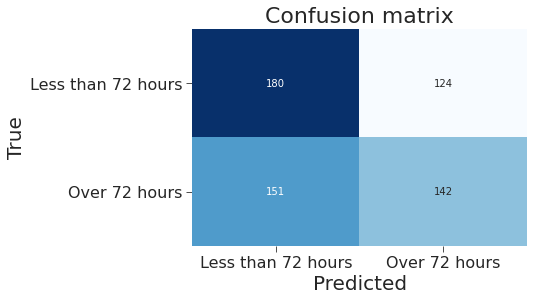

In [22]:
evaluate_model(y, y_proba_cxr, class_names, "test", show_plots=False)

Model evaluation on the test set

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       304
           1       0.80      0.77      0.79       293

    accuracy                           0.80       597
   macro avg       0.80      0.80      0.80       597
weighted avg       0.80      0.80      0.80       597



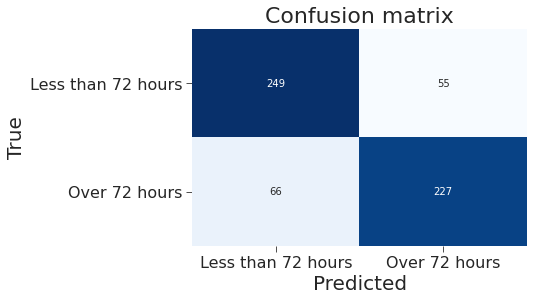

In [28]:
evaluate_model(y, y_proba_combined, class_names, "test", show_plots=False)
plt.savefig("../results/confusion-matrix.jpeg", bbox_inches='tight', dpi=300, pad_inches=0);

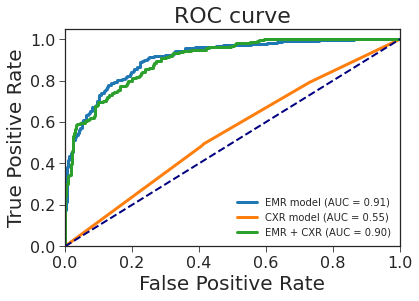

In [51]:
y_dummy = pd.get_dummies(y, drop_first=False).values

plt.figure();

labels = ["EMR model", "CXR model", "EMR + CXR"]
i = 0

for y_proba in [y_proba_emr, y_proba_cxr, y_proba_combined]: 
    fpr, tpr, _ = roc_curve(y_dummy[:,1], y_proba[:,1])
    roc_auc = roc_auc_score(y_dummy[:,1], y_proba[:,1])
    labels[i] = labels[i] + " (AUC = %0.2f)" % roc_auc
    plt.plot(fpr, tpr, lw=3)
    i += 1

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right", labels=labels);

plt.savefig("../results/ROC.jpeg", bbox_inches='tight', dpi=300, pad_inches=0);

In [37]:
labels

['EMR model', 'CXR model', 'EMR + CXR']